<a href="https://colab.research.google.com/github/fatsoengineer/Computer_Vision_Course/blob/master/S5/2nd_Model_Param_Reduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to 1st Step [Notebook_1](https://github.com/fatsoengineer/Computer_Vision_Course/blob/master/S5/1st_Model.ipynb)

## Step 2

 **Target:**

> After Creation of Base Model, Reduce number of parameters


**Results**


> 
*   Total params: 9,648
*   Best Test Accuracy: 
```
EPOCH: 13
Loss=0.02335897646844387 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 38.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0317, Accuracy: 9905/10000 (99.05%)
```


**Analysis**

> * Played around with no of output channels size to reduce parameters keeping in mind that that the results dont fall behind much from the step 1
* Ran multiple times to confirm that the results are not fluke or not fluctuating from each training at large 




# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
from torchsummary import summary

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


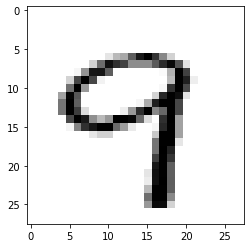

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

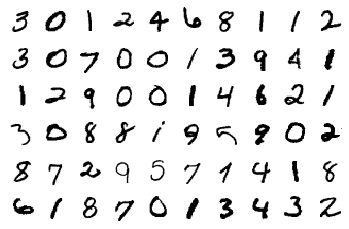

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),

            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
           
            nn.ReLU(),

            nn.MaxPool2d(2,2), # 14
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU(),

            nn.MaxPool2d(2,2), #5
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU(),
        )

        self.reducer = nn.Conv2d(20,10,3,bias=False)

    def forward(self, x):
      x= self.conv1(x)
      x= self.conv2(x)
      x= self.conv3(x)
      x= self.reducer(x)
      x = x.view(-1, 10)
      return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 12, 28, 28]             864
              ReLU-4           [-1, 12, 28, 28]               0
         MaxPool2d-5           [-1, 12, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           1,728
              ReLU-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           2,304
              ReLU-9           [-1, 16, 10, 10]               0
        MaxPool2d-10             [-1, 16, 5, 5]               0
           Conv2d-11             [-1, 20, 3, 3]           2,880
             ReLU-12             [-1, 20, 3, 3]               0
           Conv2d-13             [-1, 10, 1, 1]           1,800
Total params: 9,648
Trainable para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.27812743186950684 Batch_id=468 Accuracy=78.38: 100%|██████████| 469/469 [00:11<00:00, 40.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0933, Accuracy: 9702/10000 (97.02%)

EPOCH: 2


Loss=0.162412628531456 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:11<00:00, 39.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9785/10000 (97.85%)

EPOCH: 3


Loss=0.06629358232021332 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:11<00:00, 39.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Loss=0.034752920269966125 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9869/10000 (98.69%)

EPOCH: 5


Loss=0.006291126366704702 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:11<00:00, 40.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9875/10000 (98.75%)

EPOCH: 6


Loss=0.030705779790878296 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:11<00:00, 40.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9884/10000 (98.84%)

EPOCH: 7


Loss=0.0015280594816431403 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:11<00:00, 39.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9875/10000 (98.75%)

EPOCH: 8


Loss=0.046415943652391434 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:11<00:00, 41.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.02616661787033081 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 39.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9885/10000 (98.85%)

EPOCH: 10


Loss=0.011720672249794006 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 45.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.018281588330864906 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


Loss=0.005785991903394461 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9883/10000 (98.83%)

EPOCH: 13


Loss=0.02335897646844387 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 38.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.0016733905067667365 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:11<00:00, 39.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9889/10000 (98.89%)

EPOCH: 15


Loss=0.0032772719860076904 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]



Test set: Average loss: 0.0369, Accuracy: 9891/10000 (98.91%)



Text(0.5, 1.0, 'Test Accuracy')

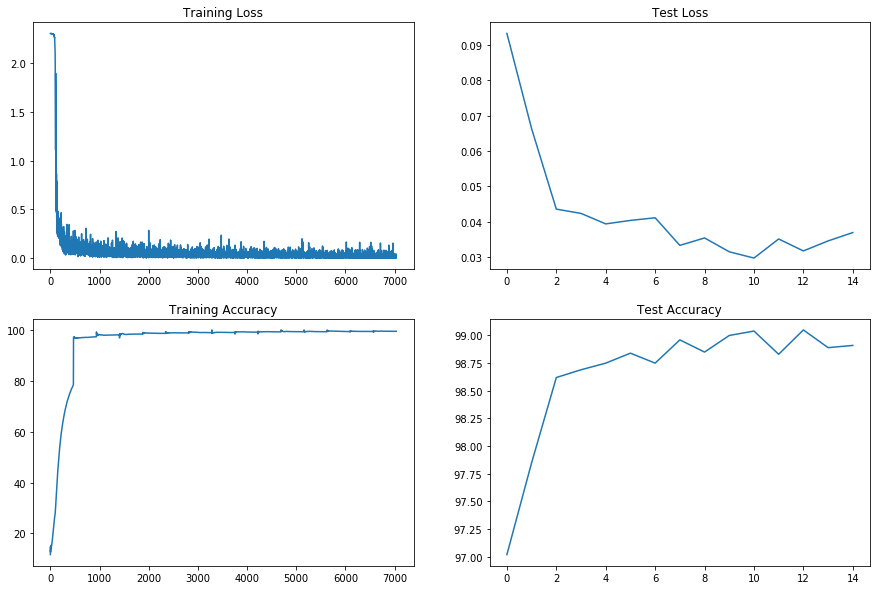

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")